## PART 1: Generate Daily Sentiment Embeddings (CLS / Mean / Max)

In [4]:
# Install dependencies
#!pip install transformers datasets tensorflow pandas numpy

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Setup
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from datasets import load_dataset
from collections import defaultdict
import pickle

output_dir = "/content/drive/MyDrive/DataSci266_Final_Project/finbert_embeddings"
os.makedirs(output_dir, exist_ok=True)

# Load model and tokenizer
model_name = "StephanAkkerman/FinTwitBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

# Load dataset
dataset = load_dataset("StephanAkkerman/financial-tweets", split="train")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

In [5]:
def get_embeddings_batch(text_list):
    # Tokenize entire batch
    inputs = tokenizer(
        text_list, return_tensors="tf", truncation=True, padding=True
    )
    outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state  # shape: (batch, seq_len, 768)

    # [CLS] token
    cls = last_hidden[:, 0, :].numpy()

    # Mean and Max pooling
    mean = tf.reduce_mean(last_hidden, axis=1).numpy()
    max_ = tf.reduce_max(last_hidden, axis=1).numpy()

    return cls, mean, max_

In [6]:
# Average embeddings per day
from datetime import datetime
embedding_sums = defaultdict(lambda: {"cls": [], "mean": [], "max": []})
daily_sentiment_scores = defaultdict(list)

skipped = 0
batch_size = 64
texts, dates, sentiments = [], [], []

# Collect data
for ex in tqdm(dataset, desc="Embedding tweets"):
    try:
        if not ex.get("timestamp") or not ex.get("description") or ex.get("sentiment") is None:
            skipped += 1
            continue
        texts.append(ex["description"])
        dates.append(ex["timestamp"].split("T")[0])
        sentiments.append(ex["sentiment"])
    except Exception as e:
        print("Skipping tweet due to:", e)
        skipped += 1

print(f"✅ Collected {len(texts)} tweets")
print(f"⛔ Skipped {skipped} tweets with missing fields")

# Process in batches
for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch_texts = texts[i:i + batch_size]
    batch_dates = dates[i:i + batch_size]
    batch_sentiments = sentiments[i:i + batch_size]  # ✅ Fix is here

    try:
        cls_arr, mean_arr, max_arr = get_embeddings_batch(batch_texts)

        for j in range(len(batch_texts)):
            date = batch_dates[j]
            daily_sentiment_scores[date].append(batch_sentiments[j])  # ✅ Now valid
            embedding_sums[date]["cls"].append(cls_arr[j])
            embedding_sums[date]["mean"].append(mean_arr[j])
            embedding_sums[date]["max"].append(max_arr[j])

    except Exception as e:
        print(f"⚠️ Error in batch {i}: {e}")

Embedding tweets: 100%|██████████| 314732/314732 [00:34<00:00, 9139.67it/s]


✅ Collected 68105 tweets
⛔ Skipped 246627 tweets with missing fields


Embedding batches: 100%|██████████| 1065/1065 [10:44<00:00,  1.65it/s]


In [7]:
print("✅ Number of unique dates with embeddings:", len(embedding_sums))
sample_date = next(iter(embedding_sums)) if embedding_sums else None
print("🗓️ Example date:", sample_date)
print("📐 CLS shape for that day:", np.array(embedding_sums[sample_date]["cls"]).shape if sample_date else "N/A")

✅ Number of unique dates with embeddings: 444
🗓️ Example date: 2023-11-14
📐 CLS shape for that day: (163, 768)


In [10]:
# Average per day
daily_embeddings = {
    'date': [],
    'cls': [],
    'mean': [],
    'max': [],
    'avg_sentiment': []
}

# Create a mapping from sentiment labels to numerical values
sentiment_mapping = {'Bullish': 1, 'Bearish': -1, 'Neutral': 0}

for date in embedding_sums:
    daily_embeddings["date"].append(date)

    for key in ["cls", "mean", "max"]:
        arr = np.stack(embedding_sums[date][key])
        daily_embeddings[key].append(arr.mean(axis=0))  # ✅ Fixed: closing parenthesis

    # ✅ Correct: avg_score calculation inside the loop
    # Convert sentiment scores to numeric before calculating the mean
    sentiment_scores = [sentiment_mapping.get(score, 0) for score in daily_sentiment_scores[date]]
    avg_score = np.mean(sentiment_scores) if sentiment_scores else 0
    daily_embeddings["avg_sentiment"].append(avg_score)
# Final DataFrame
emb_df = pd.DataFrame(daily_embeddings)
emb_df["date"] = pd.to_datetime(emb_df["date"])
emb_df = emb_df.sort_values("date")

print("✅ Daily embeddings generated:", len(emb_df))
print("📅 Date range:", emb_df['date'].min(), "→", emb_df['date'].max())
print(emb_df.head())
print("✅ Unique dates:", emb_df["date"].nunique())

# Save
with open(f"{output_dir}/daily_sentiment_embeddings.pkl", "wb") as f:
    pickle.dump(emb_df, f)

print("Saved daily sentiment embeddings to Google Drive.")

✅ Daily embeddings generated: 444
📅 Date range: 2021-12-27 00:00:00 → 2024-04-03 00:00:00
          date                                                cls  \
441 2021-12-27  [-0.23162088, -0.537831, -0.11581464, 0.582418...   
440 2022-01-02  [-0.22748329, -0.61845094, -0.04058229, 0.4155...   
439 2022-01-03  [-0.15400232, -0.5237716, -0.059607867, 0.4547...   
438 2022-01-04  [-0.17182718, -0.5494433, -0.0702886, 0.569090...   
437 2022-01-05  [-0.11933209, -0.53722817, -0.1544225, 0.46808...   

                                                  mean  \
441  [-0.39374432, -0.44676203, -0.3779505, 0.55620...   
440  [-0.45924956, -0.51103616, -0.19575621, 0.3937...   
439  [-0.34352374, -0.42859635, -0.23460747, 0.4499...   
438  [-0.35483292, -0.42010704, -0.23844147, 0.4636...   
437  [-0.3026388, -0.44002488, -0.29311842, 0.45087...   

                                                   max  avg_sentiment  
441  [0.98006344, 1.0974677, 1.10989, 1.7251962, 1....       0.365854  
44

## STEP 1: Setup

In [12]:
!pip install ta

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from ta import add_all_ta_features

market_path = "/content/drive/MyDrive/DataSci266_Final_Project/yahoo_finance_historical_data_10year.csv"
sentiment_path = "/content/drive/MyDrive/DataSci266_Final_Project/finbert_embeddings/daily_sentiment_embeddings.pkl"
results_dir = "/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results"
os.makedirs(results_dir, exist_ok=True)

# Load sentiment
with open(sentiment_path, "rb") as f:
    sentiment_df = pickle.load(f)

print("📂 Type of loaded object:", type(sentiment_df))
print("📋 Columns:", sentiment_df.columns)
print("🔍 Sample rows:")
print(sentiment_df.head())

# Force re-parse the date column
sentiment_df = pd.read_pickle(sentiment_path)

# Convert to string first (in case of objects), then to datetime
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"].astype(str), errors='coerce')

# Drop any invalid dates
sentiment_df = sentiment_df.dropna(subset=["date"])

# Add lagged sentiment features
sentiment_df["cls_shift_1"] = sentiment_df["cls"].shift(1)
sentiment_df["cls_momentum"] = sentiment_df["cls"] - sentiment_df["cls_shift_1"]

# Confirm it worked
print("✅ Fixed Sentiment dates:", sentiment_df["date"].min(), "→", sentiment_df["date"].max())

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ce12a8447788ee476d7d36080f04d516cbf44af214174166b30608452efa84f1
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
📂 Type of loaded object: <class 'pandas.core.frame.DataFrame'>
📋 Columns: Index(['date', 'cls', 'mean', 'max', 'avg_sentiment'], dtype='object')
🔍 Sample rows:
          date                                                cls  \
441 2021-12-27  [-0.23162088, -0.537831, -0.11581464, 0.582418...   
440 2022-01-02  [-0.22748329, -0.61845094, -0.04058229, 0.4155...   
439 2022-01-03  [-0.15400232, -0.5237716, -0.059607867, 0.4547...   
438 2022-01-04  [-0.17182718, -0.5494433, -0.0702886, 0.569090...   
437 2022-01-05  [-0.11933209, -0.53722817, -0.1544225, 0.46808...   

                                                  mean  \
441  [-0.39374432, -0.44676203, -0.3779505, 0.55620...

In [13]:
from datasets import load_dataset

dataset = load_dataset("StephanAkkerman/financial-tweets", split="train")
print(dataset[0])


{'image_url': 'https://pbs.twimg.com/media/F-7h_aha8AAd-bI.jpg', 'proxy_image_url': 'https://images-ext-1.discordapp.net/external/WbqMWzDeA5HMYV5iTE52ceggupWL728HobnJu5tLnNI/https/pbs.twimg.com/media/F-7h_aha8AAd-bI.jpg', 'image_dimensions': '(649, 1200)', 'thumbnail_url': 'https://pbs.twimg.com/profile_images/1542955742084435969/rpdLw6y2_normal.jpg', 'proxy_thumbnail_url': 'https://images-ext-1.discordapp.net/external/SiPBppp4J9AakndUpz3-m-VZ_T-RYzgIieQIzli0hKY/https/pbs.twimg.com/profile_images/1542955742084435969/rpdLw6y2_normal.jpg', 'thumbnail_dimensions': '(48, 48)', 'timestamp': '2023-11-14T23:06:39.390000+00:00', 'description': 'Crazy that $PRIME is going to >$1B market cap at the next cycle top as the “ $AXS of this cycle” and you still don’t own any anon. \n\n$75-100 exit or bust bitch.', 'url': 'https://twitter.com/user/status/1724564208602513837', 'embed_title': 'Crypto Mikey tweeted about PRIME, AXS', 'tweet_type': 'tweet', 'financial_info': "[{'ticker': '$PRIME', 'exchang

## STEP 2: Preprocess 10-Year Market Data

In [14]:
market_df = pd.read_csv(market_path, skiprows=[1, 2])
market_df = market_df.rename(columns={"Price": "Date"})
market_df["Date"] = pd.to_datetime(market_df["Date"])

tickers = market_df.iloc[0, 1::5].values
market_df = market_df[2:]

data = []
for i, ticker in enumerate(tickers):
    try:
        df = pd.DataFrame({
            "Date": market_df["Date"],
            "Ticker": ticker,
            "Close": market_df[f"Close.{i}"].astype(float),
            "Open": market_df[f"Open.{i}"].astype(float),
            "High": market_df[f"High.{i}"].astype(float),
            "Low": market_df[f"Low.{i}"].astype(float),
            "Volume": market_df[f"Volume.{i}"].astype(float),
        })
        df["Next_Close"] = df["Close"].shift(-1)
        df["Return"] = (df["Next_Close"] - df["Close"]) / df["Close"]
        # Add engineered features
        df["ret_1"] = df["Return"].shift(1)
        df["ret_3"] = df["Return"].rolling(3).mean()
        df["ret_5"] = df["Return"].rolling(5).mean()
        df["ret_vol_5"] = df["Return"].rolling(5).std()
        df["ret_ratio_5"] = df["ret_5"] / (df["ret_vol_5"] + 1e-6)
        df = df.dropna()
        data.append(df)
    except:
        continue

market_long = pd.concat(data)
market_long = market_long.groupby("Ticker").apply(lambda x: add_all_ta_features(
    x, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)).reset_index(drop=True)

# Filter dates to sentiment range
start_date = sentiment_df["date"].min()
end_date = sentiment_df["date"].max()
market_long = market_long[(market_long["Date"] >= start_date) & (market_long["Date"] <= end_date)]
# Merge with sentiment
combined = market_long.merge(sentiment_df, left_on="Date", right_on="date").drop(columns=["date"])
print("Combined data shape:", combined.shape)
print("Date range:", combined["Date"].min(), "to", combined["Date"].max())


✅ Combined data shape: (1212, 106)
📅 Date range: 2021-12-27 00:00:00 to 2023-12-22 00:00:00


<ipython-input-14-49454e4b08bf>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  market_long = market_long.groupby("Ticker").apply(lambda x: add_all_ta_features(


## STEP 3: Create Sequences for LSTM

In [15]:
def create_sequences(df, sentiment_key, window=10):
    X_seq, y = [], []
    sentiment = np.stack(df[sentiment_key].values)
    market = df.select_dtypes(include=[np.number]).drop(columns=["Return", "Next_Close"])
    market_scaled = StandardScaler().fit_transform(market)
    full = np.concatenate([sentiment, market_scaled], axis=1)

    for i in range(len(df) - window - 1):
        X_seq.append(full[i:i+window])
        y.append(df["Return"].iloc[i + window])
    return np.array(X_seq), np.array(y)


##STEP 4: Train Dense + LSTM Per Embedding & Ticker

In [16]:
def train_models(ticker, df, embedding_key, window=10):
    X_seq, y = create_sequences(df, embedding_key, window)
    if len(X_seq) < 50:
        return None

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y[:split], y[split:]

    # Dense
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    dense = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],)),
        tf.keras.layers.Dense(1)
    ])
    dense.compile(optimizer='adam', loss='mae')
    dense.fit(X_train_flat, y_train, epochs=10, batch_size=32, verbose=0)
    pred_dense = dense.predict(X_test_flat).flatten()

    # LSTM
    lstm = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(window, X_seq.shape[2])),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.LSTM(32, dropout=0.2),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    lstm.compile(optimizer='adam', loss='mae')
    lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    pred_lstm = lstm.predict(X_test).flatten()

    return {
        "dense": {
            "mae": mean_absolute_error(y_test, pred_dense),
            "acc": accuracy_score(y_test > 0, pred_dense > 0),
            "y_pred": pred_dense,
            "y_true": y_test
        },
        "lstm": {
            "mae": mean_absolute_error(y_test, pred_lstm),
            "acc": accuracy_score(y_test > 0, pred_lstm > 0),
            "y_pred": pred_lstm,
            "y_true": y_test
        }
    }

## STEP 5: Run All and Save Results + Plots

In [17]:
import json
import os

checkpoint_dir = os.path.join(results_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

results = []

for embedding_key in ['cls', 'mean', 'max']:
    for ticker in tqdm(combined['Ticker'].unique(), desc=f"Embedding: {embedding_key}"):
        df_t = combined[combined['Ticker'] == ticker].copy()

        for model_type in ['dense', 'lstm']:
            # ✅ Check if result already exists
            checkpoint_file = os.path.join(checkpoint_dir, f"{ticker}_{embedding_key}_{model_type}.pkl")
            if os.path.exists(checkpoint_file):
                print(f"⏭️ Skipping {ticker}-{embedding_key}-{model_type}, already done.")
                continue

            try:
                # Train model
                metrics = train_models(ticker, df_t, embedding_key)
                if not metrics:
                    continue

                res = metrics[model_type]
                result = {
                    "Ticker": ticker,
                    "Embedding": embedding_key,
                    "Model": model_type.upper(),
                    "MAE": res["mae"],
                    "Accuracy": res["acc"]
                }
                results.append(result)

                # ✅ Save checkpoint
                with open(checkpoint_file, "wb") as f:
                    pickle.dump(result, f)

            except Exception as e:
                print(f"⚠️ {ticker} ({embedding_key}-{model_type}): {e}")


Embedding: cls: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]


⏭️ Skipping 17.18082158752494-cls-dense, already done.
⏭️ Skipping 17.18082158752494-cls-lstm, already done.
⏭️ Skipping 17.2947338904156-cls-dense, already done.
⏭️ Skipping 17.2947338904156-cls-lstm, already done.
⏭️ Skipping 17.336750396463433-cls-dense, already done.
⏭️ Skipping 17.336750396463433-cls-lstm, already done.
⏭️ Skipping 234684800.0-cls-dense, already done.
⏭️ Skipping 234684800.0-cls-lstm, already done.


Embedding: mean: 100%|██████████| 4/4 [00:00<00:00, 644.71it/s]


⏭️ Skipping 17.18082158752494-mean-dense, already done.
⏭️ Skipping 17.18082158752494-mean-lstm, already done.
⏭️ Skipping 17.2947338904156-mean-dense, already done.
⏭️ Skipping 17.2947338904156-mean-lstm, already done.
⏭️ Skipping 17.336750396463433-mean-dense, already done.
⏭️ Skipping 17.336750396463433-mean-lstm, already done.
⏭️ Skipping 234684800.0-mean-dense, already done.
⏭️ Skipping 234684800.0-mean-lstm, already done.


Embedding: max: 100%|██████████| 4/4 [00:00<00:00, 627.87it/s]

⏭️ Skipping 17.18082158752494-max-dense, already done.
⏭️ Skipping 17.18082158752494-max-lstm, already done.
⏭️ Skipping 17.2947338904156-max-dense, already done.
⏭️ Skipping 17.2947338904156-max-lstm, already done.
⏭️ Skipping 17.336750396463433-max-dense, already done.
⏭️ Skipping 17.336750396463433-max-lstm, already done.
⏭️ Skipping 234684800.0-max-dense, already done.
⏭️ Skipping 234684800.0-max-lstm, already done.


## AFTER TRAINING: Combine Checkpoints into Final CSV

In [18]:
# Combine all checkpoints into one final CSV
import glob

all_checkpoints = glob.glob(f"{checkpoint_dir}/*.pkl")
all_results = []

for cp in all_checkpoints:
    with open(cp, "rb") as f:
        result = pickle.load(f)
        all_results.append(result)

final_df = pd.DataFrame(all_results)
final_df.to_csv(f"{results_dir}/embedding_lstm_comparison.csv", index=False)
print("✅ All results consolidated and saved.")

✅ All results consolidated and saved.


In [19]:
# Get all .pkl files in the checkpoint directory
result_files = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pkl")]

results = {}

for file in result_files:
    name = file.replace("results_", "").replace(".pkl", "")
    with open(os.path.join(checkpoint_dir, file), "rb") as f:
        results[name] = pickle.load(f)

##Step 1: Load Results

In [20]:
results_path = f"{results_dir}/embedding_lstm_comparison.csv"
df = pd.read_csv(results_path)
df.head()

,Ticker,Embedding,Model,MAE,Accuracy
0,17.180822,cls,DENSE,0.014617,0.491525
1,17.180822,cls,LSTM,0.030249,0.474576
2,17.294734,cls,DENSE,0.049473,0.593220
3,17.294734,cls,LSTM,0.056543,0.644068
4,17.336750,cls,DENSE,0.022454,0.457627


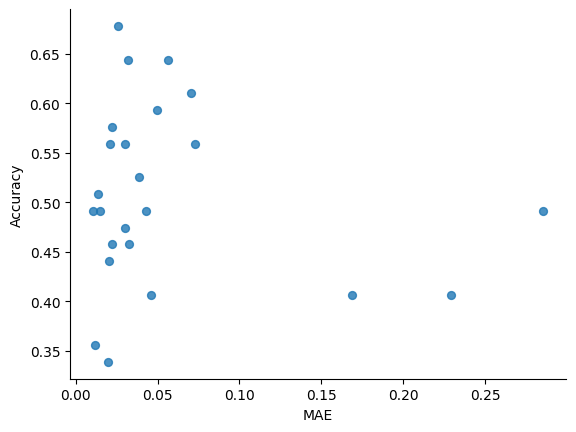

In [21]:
# @title MAE vs Accuracy

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='MAE', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

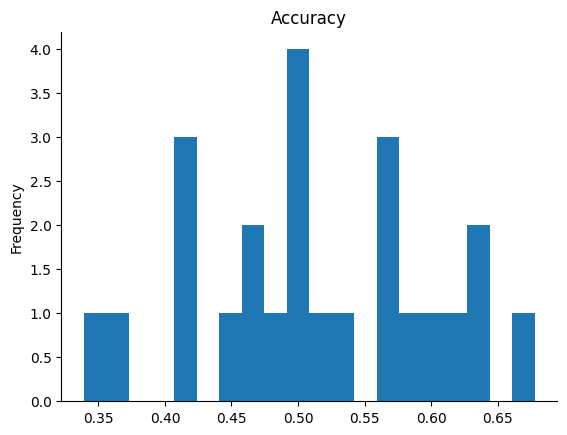

In [22]:
# @title Accuracy

from matplotlib import pyplot as plt
df['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

##Step 2: Summary Table

In [23]:
summary = df.groupby(["Model", "Embedding"]).agg({
    "MAE": "mean",
    "Accuracy": "mean"
}).reset_index()

summary.to_csv(f"{results_dir}/summary_metrics.csv", index=False)
print(summary)


   Model Embedding       MAE  Accuracy
0  DENSE       cls  0.028125  0.555085
1  DENSE       max  0.175961  0.436441
2  DENSE      mean  0.030017  0.491525
3   LSTM       cls  0.040513  0.516949
4   LSTM       max  0.016150  0.474576
5   LSTM      mean  0.051155  0.567797


## Step 3: Bar Charts

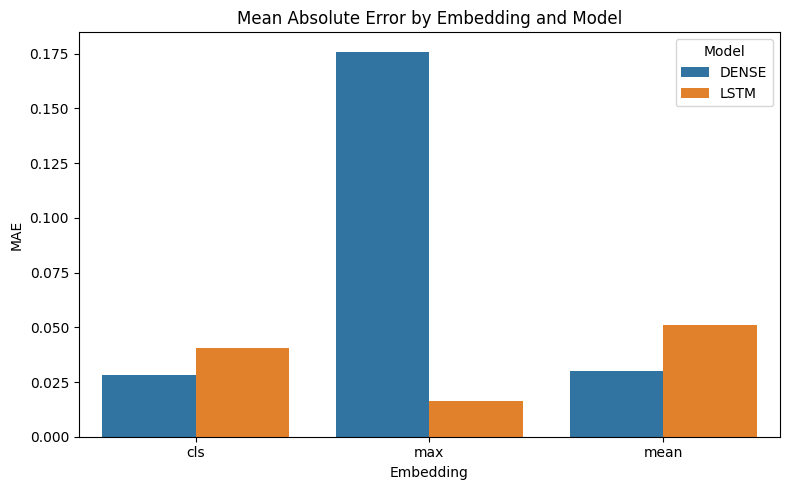

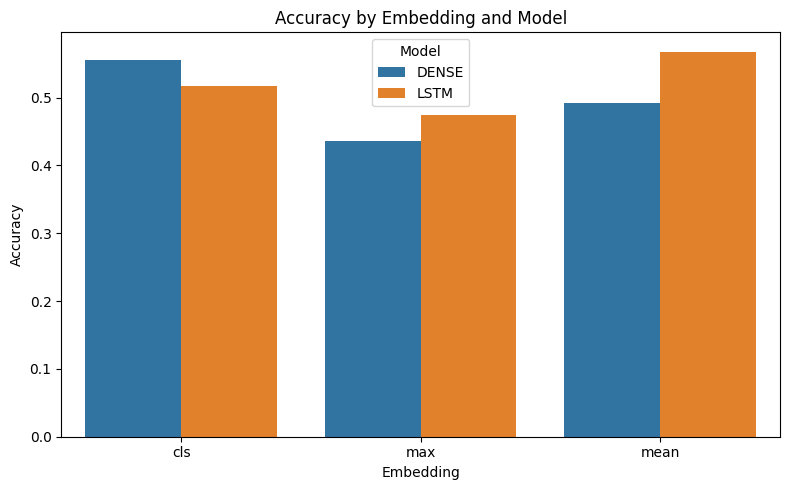

In [24]:
# Bar plot - MAE
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x="Embedding", y="MAE", hue="Model")
plt.title("Mean Absolute Error by Embedding and Model")
plt.tight_layout()
plt.savefig(f"{results_dir}/bar_mae.png")
plt.show()

# Bar plot - Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x="Embedding", y="Accuracy", hue="Model")
plt.title("Accuracy by Embedding and Model")
plt.tight_layout()
plt.savefig(f"{results_dir}/bar_accuracy.png")
plt.show()


## Step 4: MAE Heatmap by Ticker

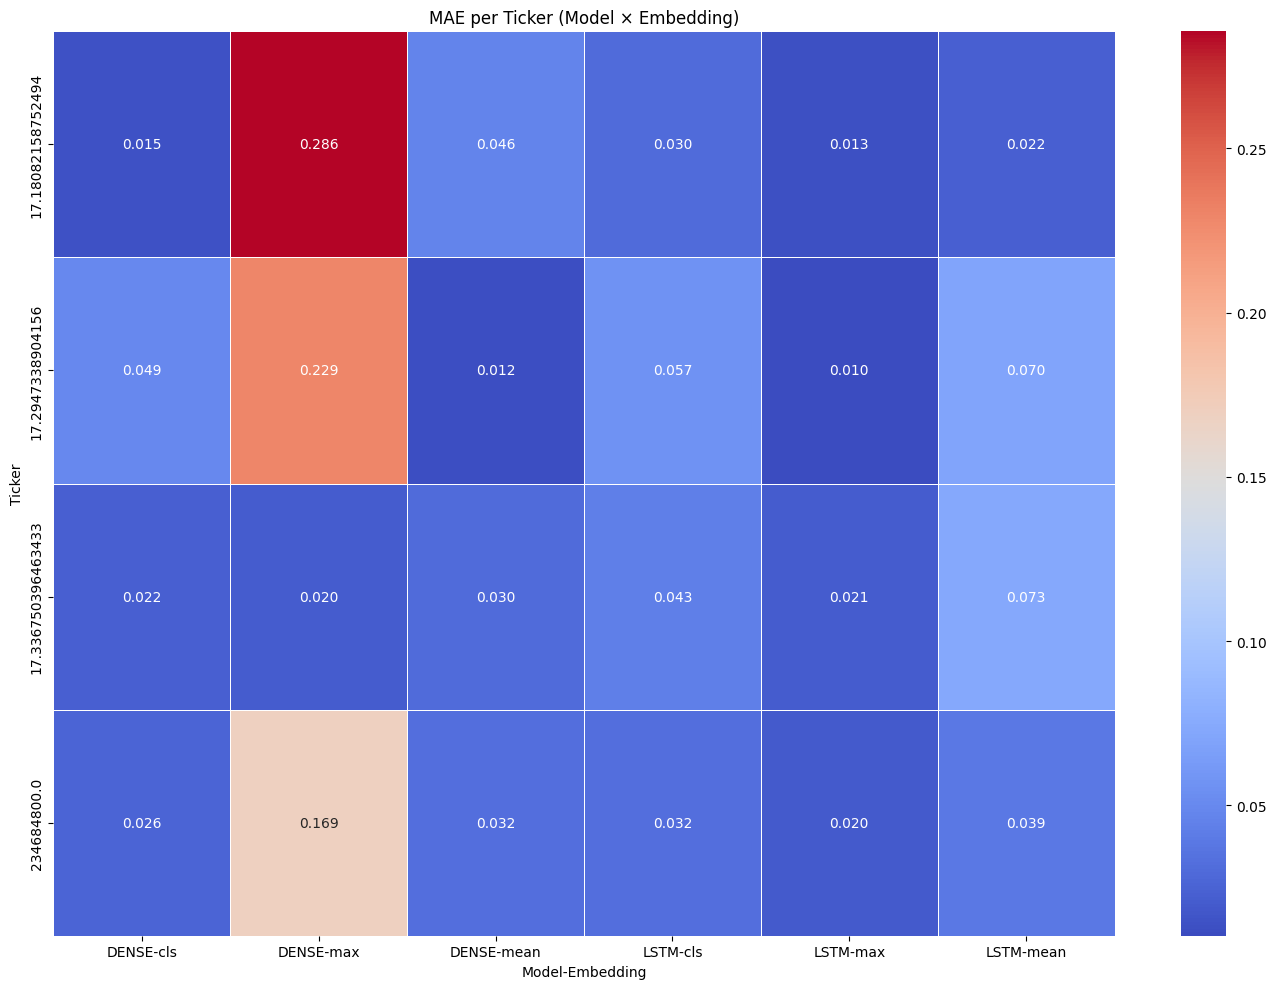

In [25]:
heatmap_mae = df.pivot_table(index="Ticker", columns=["Model", "Embedding"], values="MAE")

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_mae, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("MAE per Ticker (Model × Embedding)")
plt.tight_layout()
plt.savefig(f"{results_dir}/heatmap_mae.png")
plt.show()


In [54]:
# Naïve model: always predict yesterday's return

# Load market data to get 'Return' column
market_path = "/content/drive/MyDrive/DataSci266_Final_Project/yahoo_finance_historical_data_10year.csv"
market_df = pd.read_csv(market_path, skiprows=[1, 2])
# ... (rest of your market data preprocessing as before) ...

# Access 'Return' column from the market DataFrame (market_long)
y = market_long['Return']
y_true = y[1:]
y_naive = y.shift(1).fillna(0)[1:]

# MAE / Accuracy
mae_naive = mean_absolute_error(y_true, y_naive)
acc_naive = accuracy_score(y_true > 0, y_naive > 0)

print(f"Naïve Model MAE: {mae_naive}")
print(f"Naïve Model Accuracy: {acc_naive}")


Naïve Model MAE: 0.026211976129354976
Naïve Model Accuracy: 0.49049845786488905


In [30]:
# Load combined dataset with avg_sentiment
market_path = "/content/drive/MyDrive/DataSci266_Final_Project/yahoo_finance_historical_data_10year.csv"
market_df = pd.read_csv(market_path, skiprows=[1, 2])
# Load sentiment data
with open(sentiment_path, "rb") as f:
  sentiment_df = pickle.load(f)

# Merge market and sentiment data
combined = market_long.merge(sentiment_df, left_on="Date", right_on="date").drop(columns=["date"])

In [31]:
# Config
window = 10
binary = False  # Set to True for classification

# Feature configurations
feature_modes = ["price-only", "sentiment-only", "combined"]
embedding_types = ["cls", "mean", "max"]
models = ["dense", "lstm"]

# Extract relevant numeric columns (for price features)
numeric_features = combined.select_dtypes(include=[np.number]).columns.tolist()
exclude = ["Return", "Next_Close"] + ["avg_sentiment"]
price_cols = [col for col in numeric_features if col not in exclude]

results = []

def create_sequences(df, sentiment_key, mode="combined", window=10):
    sentiment = np.stack(df[sentiment_key].values)
    price = df[price_cols].values
    scaler = StandardScaler()
    price_scaled = scaler.fit_transform(price)

    # Select feature set
    if mode == "price-only":
        X_full = price_scaled
    elif mode == "sentiment-only":
        X_full = sentiment
    else:  # combined
        sentiment_feat = sentiment
        if "avg_sentiment" in df:
            sentiment_feat = np.concatenate([sentiment, df[["avg_sentiment"]].values], axis=1)
        X_full = np.concatenate([sentiment_feat, price_scaled], axis=1)

    X_seq, y = [], []
    for i in range(len(df) - window - 1):
        X_seq.append(X_full[i:i+window])
        if binary:
            y.append(int(df["Return"].iloc[i + window] > 0))
        else:
            y.append(df["Return"].iloc[i + window])
    return np.array(X_seq), np.array(y)

def build_dense(input_shape):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(1 if not binary else 1, activation='sigmoid' if binary else None)
    ])

def build_lstm(input_shape):
    return tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.LSTM(32, dropout=0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1 if not binary else 1, activation='sigmoid' if binary else None)
    ])

# Run all combinations
for feature_mode in feature_modes:
    for embedding_key in embedding_types:
        for model_type in models:
            for ticker in tqdm(combined['Ticker'].unique(), desc=f"{feature_mode}-{embedding_key}-{model_type}"):
                df_t = combined[combined['Ticker'] == ticker].copy()
                try:
                    X_seq, y = create_sequences(df_t, embedding_key, mode=feature_mode, window=window)
                    if len(X_seq) < 50:
                        continue

                    split = int(0.8 * len(X_seq))
                    X_train, X_test = X_seq[:split], X_seq[split:]
                    y_train, y_test = y[:split], y[split:]

                    if model_type == "dense":
                        X_train_flat = X_train.reshape(X_train.shape[0], -1)
                        X_test_flat = X_test.reshape(X_test.shape[0], -1)
                        model = build_dense(X_train_flat.shape[1])
                        X_tr, X_te = X_train_flat, X_test_flat
                    else:
                        model = build_lstm(X_train.shape[1:])
                        X_tr, X_te = X_train, X_test

                    loss = 'binary_crossentropy' if binary else 'mae'
                    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'] if binary else [])
                    model.fit(X_tr, y_train, epochs=10, batch_size=32, verbose=0)
                    y_pred = model.predict(X_te).flatten()

                    if binary:
                        y_bin = (y_pred > 0.5).astype(int)
                        acc = accuracy_score(y_test, y_bin)
                        auc = roc_auc_score(y_test, y_pred)
                        results.append({"Model": model_type.upper(), "Embedding": embedding_key, "FeatureSet": feature_mode, "Accuracy": acc, "AUC": auc})
                    else:
                        mae = mean_absolute_error(y_test, y_pred)
                        acc = accuracy_score(y_test > 0, y_pred > 0)
                        results.append({"Model": model_type.upper(), "Embedding": embedding_key, "FeatureSet": feature_mode, "MAE": mae, "Accuracy": acc})

                except Exception as e:
                    print(f"⚠️ {ticker} failed: {e}")

# Save final results
result_df = pd.DataFrame(results)
output_path = f"{results_dir}/final_model_comparison.csv"
result_df.to_csv(output_path, index=False)
print("✅ All results saved to:", output_path)

price-only-cls-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


price-only-cls-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.10s/it]

2/2 [==============================] - 0s 3ms/step


price-only-cls-dense:  50%|█████     | 2/4 [00:03<00:02,  1.45s/it]

2/2 [==============================] - 0s 4ms/step


price-only-cls-dense:  75%|███████▌  | 3/4 [00:04<00:01,  1.32s/it]

2/2 [==============================] - 0s 3ms/step


price-only-cls-lstm:   0%|          | 0/4 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x79a4a2c074c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 1s 7ms/step


price-only-cls-lstm:  25%|██▌       | 1/4 [00:10<00:31, 10.67s/it]WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x79a4a5018360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 2s 7ms/step


price-only-cls-lstm:  50%|█████     | 2/4 [00:19<00:19,  9.81s/it]

2/2 [==============================] - 1s 6ms/step


price-only-cls-lstm:  75%|███████▌  | 3/4 [00:28<00:09,  9.06s/it]

2/2 [==============================] - 1s 6ms/step


price-only-mean-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


price-only-mean-dense:  25%|██▌       | 1/4 [00:00<00:02,  1.02it/s]

2/2 [==============================] - 0s 4ms/step


price-only-mean-dense:  50%|█████     | 2/4 [00:01<00:01,  1.01it/s]

2/2 [==============================] - 0s 4ms/step


price-only-mean-dense:  75%|███████▌  | 3/4 [00:02<00:01,  1.00s/it]

2/2 [==============================] - 0s 3ms/step


price-only-mean-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 6ms/step


price-only-mean-lstm:  25%|██▌       | 1/4 [00:09<00:27,  9.07s/it]

2/2 [==============================] - 1s 6ms/step


price-only-mean-lstm:  50%|█████     | 2/4 [00:18<00:18,  9.30s/it]

2/2 [==============================] - 1s 6ms/step


price-only-mean-lstm:  75%|███████▌  | 3/4 [00:27<00:09,  9.21s/it]

2/2 [==============================] - 1s 7ms/step


price-only-max-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


price-only-max-dense:  25%|██▌       | 1/4 [00:00<00:02,  1.00it/s]

2/2 [==============================] - 0s 4ms/step


price-only-max-dense:  50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

2/2 [==============================] - 0s 4ms/step


price-only-max-dense:  75%|███████▌  | 3/4 [00:03<00:01,  1.14s/it]

2/2 [==============================] - 0s 3ms/step


price-only-max-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 6ms/step


price-only-max-lstm:  25%|██▌       | 1/4 [00:08<00:26,  8.69s/it]

2/2 [==============================] - 1s 6ms/step


price-only-max-lstm:  50%|█████     | 2/4 [00:18<00:18,  9.30s/it]

2/2 [==============================] - 2s 8ms/step


price-only-max-lstm:  75%|███████▌  | 3/4 [00:27<00:09,  9.04s/it]

2/2 [==============================] - 1s 7ms/step


sentiment-only-cls-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


sentiment-only-cls-dense:  25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-cls-dense:  50%|█████     | 2/4 [00:02<00:02,  1.04s/it]

2/2 [==============================] - 0s 5ms/step


sentiment-only-cls-dense:  75%|███████▌  | 3/4 [00:04<00:01,  1.47s/it]

2/2 [==============================] - 0s 3ms/step


sentiment-only-cls-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 7ms/step


sentiment-only-cls-lstm:  25%|██▌       | 1/4 [00:08<00:24,  8.20s/it]

2/2 [==============================] - 1s 13ms/step


sentiment-only-cls-lstm:  50%|█████     | 2/4 [00:18<00:18,  9.30s/it]

2/2 [==============================] - 1s 6ms/step


sentiment-only-cls-lstm:  75%|███████▌  | 3/4 [00:27<00:09,  9.32s/it]

2/2 [==============================] - 1s 9ms/step


sentiment-only-mean-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


sentiment-only-mean-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.07s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-mean-dense:  50%|█████     | 2/4 [00:03<00:02,  1.50s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-mean-dense:  75%|███████▌  | 3/4 [00:04<00:01,  1.36s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-mean-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 2s 7ms/step


sentiment-only-mean-lstm:  25%|██▌       | 1/4 [00:08<00:25,  8.64s/it]

2/2 [==============================] - 1s 7ms/step


sentiment-only-mean-lstm:  50%|█████     | 2/4 [00:18<00:18,  9.33s/it]

2/2 [==============================] - 1s 7ms/step


sentiment-only-mean-lstm:  75%|███████▌  | 3/4 [00:27<00:09,  9.16s/it]

2/2 [==============================] - 1s 7ms/step


sentiment-only-max-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


sentiment-only-max-dense:  25%|██▌       | 1/4 [00:01<00:03,  1.19s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-max-dense:  50%|█████     | 2/4 [00:02<00:02,  1.08s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-max-dense:  75%|███████▌  | 3/4 [00:03<00:01,  1.05s/it]

2/2 [==============================] - 0s 4ms/step


sentiment-only-max-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 6ms/step


sentiment-only-max-lstm:  25%|██▌       | 1/4 [00:09<00:27,  9.10s/it]

2/2 [==============================] - 1s 7ms/step


sentiment-only-max-lstm:  50%|█████     | 2/4 [00:17<00:16,  8.48s/it]

2/2 [==============================] - 1s 7ms/step


sentiment-only-max-lstm:  75%|███████▌  | 3/4 [00:27<00:09,  9.39s/it]

2/2 [==============================] - 1s 7ms/step


combined-cls-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


combined-cls-dense:  25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

2/2 [==============================] - 0s 4ms/step


combined-cls-dense:  50%|█████     | 2/4 [00:02<00:02,  1.05s/it]

2/2 [==============================] - 0s 3ms/step


combined-cls-dense:  75%|███████▌  | 3/4 [00:03<00:01,  1.12s/it]

2/2 [==============================] - 0s 4ms/step


combined-cls-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 6ms/step


combined-cls-lstm:  25%|██▌       | 1/4 [00:09<00:27,  9.08s/it]

2/2 [==============================] - 2s 9ms/step


combined-cls-lstm:  50%|█████     | 2/4 [00:17<00:17,  8.81s/it]

2/2 [==============================] - 1s 7ms/step


combined-cls-lstm:  75%|███████▌  | 3/4 [00:26<00:08,  8.67s/it]

2/2 [==============================] - 1s 7ms/step


combined-mean-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


combined-mean-dense:  25%|██▌       | 1/4 [00:01<00:03,  1.23s/it]

2/2 [==============================] - 0s 4ms/step


combined-mean-dense:  50%|█████     | 2/4 [00:02<00:02,  1.21s/it]

2/2 [==============================] - 0s 4ms/step


combined-mean-dense:  75%|███████▌  | 3/4 [00:03<00:01,  1.20s/it]

2/2 [==============================] - 0s 5ms/step


combined-mean-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 7ms/step


combined-mean-lstm:  25%|██▌       | 1/4 [00:10<00:32, 10.81s/it]

2/2 [==============================] - 1s 7ms/step


combined-mean-lstm:  50%|█████     | 2/4 [00:20<00:19,  9.95s/it]

2/2 [==============================] - 1s 7ms/step


combined-mean-lstm:  75%|███████▌  | 3/4 [00:28<00:09,  9.17s/it]

2/2 [==============================] - 1s 7ms/step


combined-max-dense:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


combined-max-dense:  25%|██▌       | 1/4 [00:01<00:03,  1.25s/it]

2/2 [==============================] - 0s 4ms/step


combined-max-dense:  50%|█████     | 2/4 [00:02<00:02,  1.24s/it]

2/2 [==============================] - 0s 4ms/step


combined-max-dense:  75%|███████▌  | 3/4 [00:03<00:01,  1.13s/it]

2/2 [==============================] - 0s 3ms/step


combined-max-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 1s 6ms/step


combined-max-lstm:  25%|██▌       | 1/4 [00:08<00:25,  8.48s/it]

2/2 [==============================] - 1s 7ms/step


combined-max-lstm:  50%|█████     | 2/4 [00:17<00:17,  8.86s/it]

2/2 [==============================] - 2s 8ms/step


combined-max-lstm:  75%|███████▌  | 3/4 [00:26<00:08,  8.96s/it]

2/2 [==============================] - 1s 7ms/step


combined-max-lstm: 100%|██████████| 4/4 [00:37<00:00,  9.31s/it]

✅ All results saved to: /content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/final_model_comparison.csv


✅ All results saved to: /content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/final_model_comparison.csv


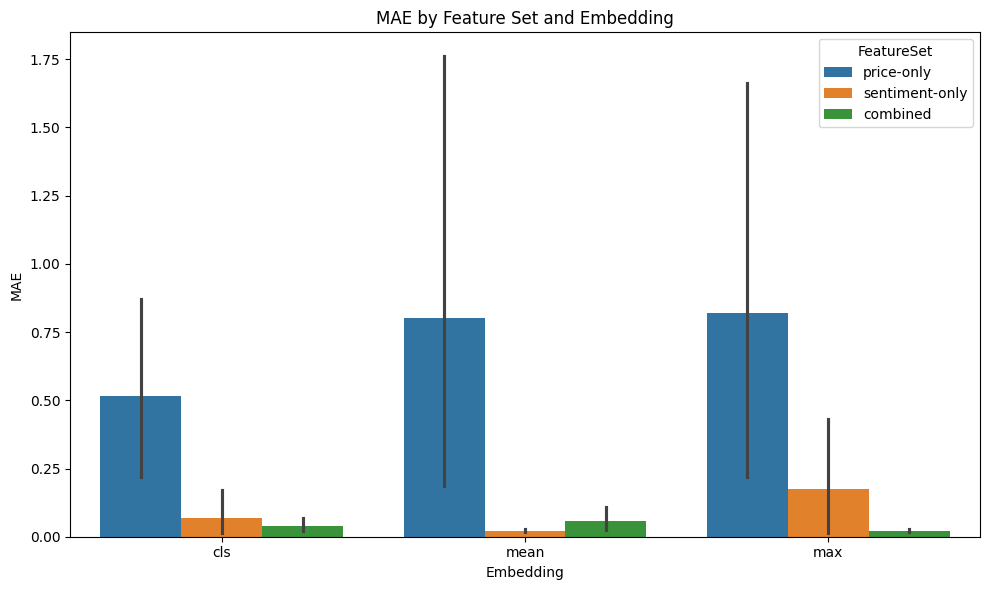

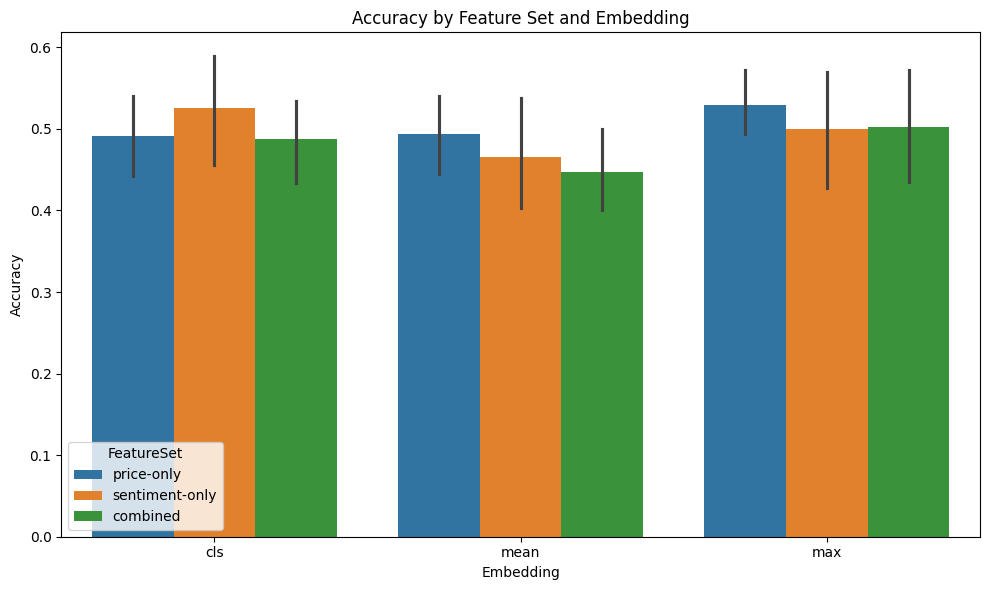

✅ Exported summary table to summary_metrics_by_feature.csv
   Model Embedding      FeatureSet       MAE  Accuracy
0  DENSE       cls        combined  0.062309  0.512712
1  DENSE       cls      price-only  0.941865  0.495763
2  DENSE       cls  sentiment-only  0.119168  0.504237
3  DENSE       max        combined  0.026856  0.483051
4  DENSE       max      price-only  1.562385  0.521186


In [32]:
print("✅ All results saved to:", output_path)

# Plot comparison
if not binary:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=result_df, x="Embedding", y="MAE", hue="FeatureSet")
    plt.title("MAE by Feature Set and Embedding")
    plt.tight_layout()
    plt.savefig(f"{results_dir}/mae_feature_comparison.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=result_df, x="Embedding", y="Accuracy", hue="FeatureSet")
    plt.title("Accuracy by Feature Set and Embedding")
    plt.tight_layout()
    plt.savefig(f"{results_dir}/accuracy_feature_comparison.png")
    plt.show()
else:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=result_df, x="Embedding", y="Accuracy", hue="FeatureSet")
    plt.title("Binary Classification Accuracy")
    plt.tight_layout()
    plt.savefig(f"{results_dir}/binary_accuracy_comparison.png")
    plt.show()

# Export summary table
summary_cols = ['Model', 'Embedding', 'FeatureSet']
metrics = ['MAE', 'Accuracy'] if not binary else ['Accuracy', 'AUC']
summary = result_df.groupby(summary_cols)[metrics].mean().reset_index()
summary.to_csv(f"{results_dir}/summary_metrics_by_feature.csv", index=False)
print("✅ Exported summary table to summary_metrics_by_feature.csv")
print(summary.head())